In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
#from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import xarray as xr
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker
#from netCDF4 import Dataset
from datetime import datetime, timedelta, date
#import wrf
from matplotlib.path import Path
import matplotlib.patheffects as pe
import glob,os
import time
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import scipy
from scipy import stats

from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score

In [2]:
def polyfit(x, y, degree):
    coeffs = np.polyfit(x, y, degree)
    p = np.poly1d(coeffs)
    #calculate r-squared
    yhat = p(x)
    ybar = np.sum(y)/len(y)
    ssreg = np.sum((yhat-ybar)**2)
    sstot = np.sum((y - ybar)**2)
    results = ssreg / sstot

    return coeffs,results

In [3]:
path='/home/bwallace/DEC/2021/'

filepaths=[]
for file in sorted(os.listdir(path)):
    filepaths.append(path+file)

In [4]:
df_from_file=(pd.read_csv(f,header=None) for f in filepaths)
df=pd.concat(df_from_file)
df=df.dropna(axis=1,how='all')

In [5]:
#set a dictionary with parameter ids

parameter_id={'42101':'Carbon Monoxide','44201':'Ozone','42601':'Nitric Oxide','42602':'Nitrogen Dioxide','42603':'Oxides of Nitrogen',
              '88501':'PM2.5 Raw Data','85101':'PM10 - LC','61101':'Wind Speed','61102':'Wind Direction'}

In [6]:
#set a list of column names to be renamed
column_names=['site','data_status','action_code','datetime','parameter','duration','value','unit','qc','poc','lat','lon','GISdatum','method_code']

#rename column names 
for i,entry in enumerate(column_names):
    df=df.rename(columns={list(df)[i]:entry})

df['datetime']=df['datetime'].str.replace(r'-0500','') #drop string from the end for easier conversion into datetime object

times=pd.to_datetime(df['datetime'],format='%Y%m%dT%H%M') #take datetime column and convert it into a datetime object for indexing

df=df.set_index(times).sort_index() #set index to datetime and sort it so that it's in order
df.index.names=['date']

In [7]:
path_proto2='/data/aq/inhouse/raw/aqmon002/2021/'

folders=sorted(os.listdir(path_proto2))

proto2_filepaths=[]
for folder in folders: #only using folders 05-07 since file naming conventions are similar - 03 has different names and 04 has weird data
    if folder not in ['07','08','09','10','11']:
        continue
        
    else:
        for file in sorted(os.listdir(path_proto2+folder)):
            proto2_filepaths.append(path_proto2+folder+'/'+file)

In [8]:
coord_file=pd.read_csv(proto2_filepaths[0],header=1)
field_names=coord_file.columns.values.tolist()

unit_dict={}
for i in range(len(field_names)):
    unit_dict[field_names[i]]=coord_file[field_names[i]][0]

In [9]:
proto2_from_files=(pd.read_csv(f,skiprows=[0,2],on_bad_lines='skip') for f in proto2_filepaths)
proto2=pd.concat(proto2_from_files)

proto2=proto2.set_index(np.arange(len(proto2)))
badrows=proto2[~proto2['datetimestamp'].str.contains('2021')].index

In [10]:
proto2=proto2.drop(badrows)
    
times=pd.to_datetime(proto2['datetimestamp'],format='%Y%m%dT%H%M%S')

proto2=proto2.set_index(times)

proto2['datetimestamp']=pd.to_datetime(proto2['datetimestamp'])
proto2.index.names=['date']

In [11]:
hourmax=proto2.drop(columns=['datetimestamp','unix_time']).apply(pd.to_numeric).resample('60min').max()
hourmin=proto2.drop(columns=['datetimestamp','unix_time']).apply(pd.to_numeric).resample('60min').min()
houravg=proto2.drop(columns=['datetimestamp','unix_time']).apply(pd.to_numeric).resample('60min').mean()
hourmed=proto2.drop(columns=['datetimestamp','unix_time']).apply(pd.to_numeric).resample('60min').median()
hourstd=proto2.drop(columns=['datetimestamp','unix_time']).apply(pd.to_numeric).resample('60min').std()

In [12]:
dec_table={'42101':'CO_ppb','44201':'O3NO2_ppb','42601':'NO_ppb','42602':'NO2_ppb','88501':'pm25_std_ugm3','85101':'pm10_std_ugm3'}

In [13]:
def CO_corrector(voltdiff,temp,rh,flag1,flag2,acal,bcal,atemp,btemp,ctemp,arh,brh,crh):
    
    craw=acal*voltdiff+bcal
    
    if flag1==True:
        ct=craw/((atemp*temp)+btemp)
    elif flag1==False:
        ct=craw/((atemp*temp**2)+(btemp*temp)+ctemp)
        
    if flag2==True:
        crh=ct/((arh*rh)+(brh))
    elif flag2==False:
        crh=ct/((arh*rh**2)+(brh*rh)+crh)
    
    return craw,ct,crh

In [14]:
epa_df=pd.read_csv('/home/bwallace/DEC/Queens_DEC_data_May21-Feb22_EPA_AQS.csv',header=0)[1:]
epa_df=epa_df.set_index(pd.to_datetime(epa_df['Value.date_local']+' '+epa_df['Value.time_local'])) #combine date and time fields to create an indexable datetime index
epa_df=epa_df[epa_df['Value.sample_frequency']=='HOURLY'].sort_index() #only select parameters that return hourly values and sort the datetime index

epa_df=epa_df.rename(columns={'Value.sample_measurement':'value'}) #rename measurements field to just value

/home/bwallace/.conda/envs/analysis/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (1,2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [15]:
var_id=42101
dataset_selector='DEC' #EPA or DEC
an_mo=[9,10,11] #months to select for prediction field
year=2021

final_date=datetime(2021,11,15)

training_period_length_in_days=14
test_period_length_in_days=14

multiple_predictor_periods=True

custom_training_date=datetime(2021,9,16)
custom_predictor_date=datetime(2021,8,19)

plot=False

vd={}

##########################################################################################################################################################################

df_matching_proto2=df.loc[df.index.isin(houravg.index)]
epa_df_matching_proto2=epa_df.loc[epa_df.index.isin(houravg.index)]

# CO:42101  O3NO2:44201  NO:42601  NO2:42602

for tshift in [-5,-4,-3,-2,-1,0,1,2,3,4,5]:
    for var_id in [44201,42101,42601,42602]:

        if var_id==44201:
            dec_concentration_field=df_matching_proto2.loc[df_matching_proto2['parameter']==var_id]['value']-df_matching_proto2.loc[df_matching_proto2['parameter']==42602]['value'] #need to subtract NO2 from O3NO2 to get O3
            epa_concentration_field=epa_df_matching_proto2.loc[epa_df_matching_proto2['Value.parameter_code']==var_id]['value']*[1 if epa_df_matching_proto2.loc[epa_df_matching_proto2['Value.parameter_code']==var_id]['Value.units_of_measure'].unique()=='Parts per billion' else 1000]

            dec_concentration_field.index=dec_concentration_field.index+timedelta(hours=tshift)
            epa_concentration_field.index=epa_concentration_field.index+timedelta(hours=tshift)

        else:
            dec_concentration_field=df_matching_proto2.loc[df_matching_proto2['parameter']==var_id]['value']
            epa_concentration_field=epa_df_matching_proto2.loc[epa_df_matching_proto2['Value.parameter_code']==var_id]['value']*[1 if epa_df_matching_proto2.loc[epa_df_matching_proto2['Value.parameter_code']==var_id]['Value.units_of_measure'].unique()=='Parts per billion' else 1000]

            dec_concentration_field.index=dec_concentration_field.index+timedelta(hours=tshift)
            epa_concentration_field.index=epa_concentration_field.index+timedelta(hours=tshift)


        if dataset_selector=='EPA':
            combined_df=pd.concat([epa_concentration_field,houravg],axis=1).dropna()
        elif dataset_selector=='DEC':
            combined_df=pd.concat([dec_concentration_field,houravg],axis=1).dropna()

        #combined_df=combined_df.loc[~(combined_df['value']<0)] #uncomment this if you dont want to consider negative observed concentrations in the regression

        if var_id==44201:
            combined_df['O3_voltdiff']=(combined_df['O3NO2_V']-combined_df['NO2_V']).sub((combined_df['O3NO2_aux_V']-combined_df['NO2_aux_V']),axis=0)
            gname='O3'
        else:
            fname=dec_table[str(var_id)]
            gname_loc=fname.find('ppb')-1
            gname=fname[:gname_loc]

            combined_df[gname+'_voltdiff']=combined_df[gname+'_V'].sub(combined_df[gname+'_aux_V'],axis=0)

        #combined_df_filtered=combined_df.loc[(combined_df['temp_sht31_degC']>0) & (combined_df['temp_sht31_degC']<30) & (combined_df['rh_sht31_percent']>25) & (combined_df['rh_sht31_percent']<80) & (~np.isnan(combined_df['value'])) 
        #                                     & (abs(combined_df['value'])<(abs(combined_df['value']).mean()*10)) & (combined_df['value']!=0) & (combined_df['value']>0)]

        combined_df_filtered=combined_df.loc[(~np.isnan(combined_df['value'])) 
                                             & (combined_df['value']!=0) & (combined_df['value']!=-999) & (abs(combined_df['value'])<(abs(combined_df['value']).mean()*10))]# & (combined_df['value']<80)]


        percentile_means=[]
        #full_dataset_days=[entry for entry in np.arange(datetime(combined_df_filtered.index[0].year,combined_df_filtered.index[0].month,combined_df_filtered.index[0].day),combined_df_filtered.index[-1]-timedelta(days=test_period_length_in_days),timedelta(days=1))]

        full_dataset_days=[entry for entry in np.arange(datetime(combined_df_filtered.index[0].year,combined_df_filtered.index[0].month,combined_df_filtered.index[0].day),final_date-timedelta(days=test_period_length_in_days),timedelta(days=1))]
        full_dataset_days_for_training=[entry for entry in np.arange(datetime(combined_df_filtered.index[0].year,combined_df_filtered.index[0].month,combined_df_filtered.index[0].day),final_date-timedelta(days=training_period_length_in_days),timedelta(days=1))]

        if multiple_predictor_periods==True:
            available_predictor_days=full_dataset_days.copy()
        else:
            available_predictor_days=np.arange(custom_predictor_date,custom_predictor_date+timedelta(days=1),timedelta(days=1))

        for i,predictor_start_day in enumerate(available_predictor_days):
            
            if i==0:
                vd[str(var_id)+'_'+str(tshift)]=[]

            #combined_df=combined_df_filtered.loc[predictor_start_day:predictor_start_day+np.timedelta64(14,'D')]
            combined_df=combined_df_filtered.loc[predictor_start_day:predictor_start_day+np.timedelta64(1,'D')]

            sensor_voltdiff=combined_df[gname+'_voltdiff']
            sensor_field=combined_df['value']
            
            n=len(sensor_voltdiff)
            r2=(((n*(sensor_voltdiff*sensor_field).sum())-(sensor_voltdiff.sum()*sensor_field.sum()))/np.sqrt((n*(sensor_voltdiff**2).sum()-(sensor_voltdiff).sum()**2)*(n*(sensor_field**2).sum()-(sensor_field).sum()**2)))**2

            vd[str(var_id)+'_'+str(tshift)].append(r2)

/tmp/ipykernel_3201537/506197142.py:39: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  epa_concentration_field=epa_df_matching_proto2.loc[epa_df_matching_proto2['Value.parameter_code']==var_id]['value']*[1 if epa_df_matching_proto2.loc[epa_df_matching_proto2['Value.parameter_code']==var_id]['Value.units_of_measure'].unique()=='Parts per billion' else 1000]


In [16]:
for name,dict_ in vd.items():
    vd[name]=xr.DataArray(vd[name])
    vd[name]=vd[name].rename({'dim_0':'day'})
    vd[name]=vd[name].assign_coords({'day':available_predictor_days})

In [17]:
for var_id in [44201,42101,42601,42602]:
    vd[var_id]=xr.concat(([vd[str(var_id)+'_'+str(timeshift)] for timeshift in [-5,-4,-3,-2,-1,0,1,2,3,4,5]]),'tshift')
    vd[var_id]=vd[var_id].assign_coords({'tshift':[-5,-4,-3,-2,-1,0,1,2,3,4,5]})

In [18]:
# CO:42101  O3NO2:44201  NO:42601  NO2:42602

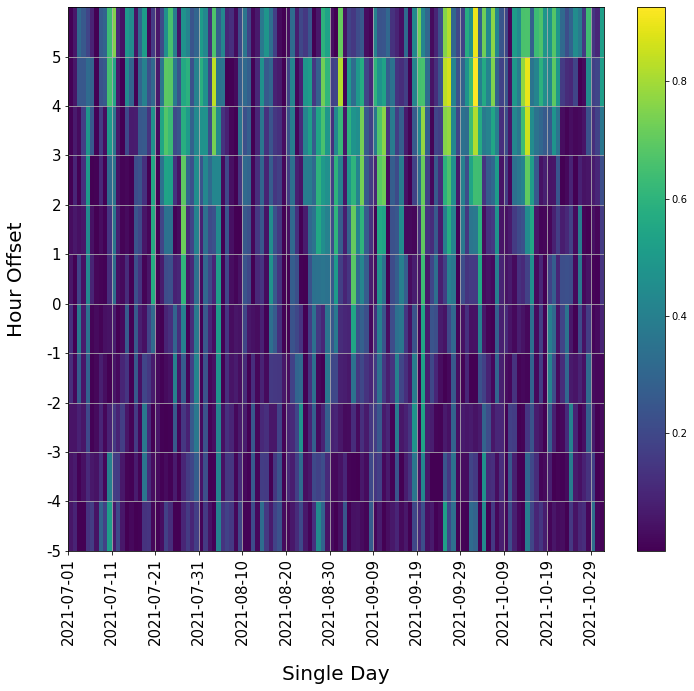

In [19]:
fig,axs=plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(12)

gas=42602

ax=axs
c=ax.pcolormesh(vd[gas])
#c=ax.pcolormesh(vd[gas].where(vd[gas]>=vd[gas].max(dim='tshift')))
ax.set_yticks(np.arange(11))
ax.set_yticklabels([-5,-4,-3,-2,-1,0,1,2,3,4,5],fontsize=15)
ax.set_xticks(np.arange(0,len(available_predictor_days),10))
ax.set_xticklabels([str(day)[:10] for day in available_predictor_days[::10]],rotation=90,fontsize=15)
ax.set_ylabel('Hour Offset',fontsize=20,labelpad=20)
ax.set_xlabel('Single Day',fontsize=20,labelpad=20)
ax.grid()

plt.colorbar(c)

plt.show()
plt.close()

In [20]:
dec_concentration_field

date
2021-07-01 05:00:00    19.86063
2021-07-01 06:00:00    13.81885
2021-07-01 07:00:00    17.11940
2021-07-01 08:00:00    22.60507
2021-07-01 09:00:00    21.83623
                         ...   
2021-11-15 09:00:00    27.24407
2021-11-15 10:00:00    28.25890
2021-11-15 11:00:00    29.87110
2021-11-15 12:00:00    27.72787
2021-11-15 13:00:00    24.31623
Name: value, Length: 3293, dtype: float64